# Introducrtion to Machine Learning: Assignment #4
## Submission date: 31\07\2024, 23:55.
### Topics:
- Ensemble methods
- AdaBoost
- PCA
- LDA
- K means clustering

**Assignment Instruction:**

· Submissions in pairs only.

· Try to keep the code as clean, concise, and short as possible

· If you wish to work in your IDE, you can, but you **must**,  insert the script back to the matching cells of the notebook and run the code. <br/>Only the notebook will be submitted in moodle (in `.ipynb` format).

· <font color='red'>Please write your answers to question in red</font>.

**Important:** All plots, results and outputs should be included in the notebook as the cells' outputs (run all cells and do not clear the output). <br/>

**Important:** Your submission must be entirely your own. Any attempts of plagiarism (including ChatGPT) will lead to grade 0 and disciplinary actions.


## Question 1 - Bagging
In HW3, you helped Charles Darvin with regression of abalone problem and now, you will try combining multiple regression models instead of just one, hopefully for a better result.

In [1]:
# import libraries

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()

In [2]:
# load the data, transform it

df = pd.read_csv('https://sharon.srworkspace.com/ml/datasets/hw3/abalone.csv', header=None)
data = df.to_numpy()

train, test = train_test_split(data, test_size=0.2, random_state=21)

X_train, y_train = train[:,:-1], train[:, -1]
X_test, y_test = test[:,:-1], test[:, -1]

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Your task is to complete the following bagging model. Specifically:
- fit(self, data, targets) - train n_estimators regressors, each with data in size n=len(data) that is drawn from the original data, with repititions.
- predict(self, test) - predict the result for all the regressors as learned.



In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.utils import resample

class LinRegCombiner():
    def __init__(self, n_estimators):
        self.n_estimators = n_estimators

    def fit(self, data, targets):
        self.regressors = []

        for _ in range(self.n_estimators):
            # Implement here
            X_resampled, y_resampled = resample(data, targets, replace=True, random_state=21)
            regressor = LinearRegression()
            regressor.fit(X_resampled, y_resampled)
            self.regressors.append(regressor)

    def predict(self, test):
        preds = np.zeros((len(test), self.n_estimators))
        # Implement here
        for i, regressor in enumerate(self.regressors):
            preds[:, i] = regressor.predict(test)

        return np.mean(preds, axis=1)

    def score(self, test, targets):
        temp = self.predict(test)
        return np.mean((targets - temp) ** 2)

In [4]:
# Run for 100 estimators

obj = LinRegCombiner(n_estimators=100)
obj.fit(X_train, y_train)

mse = obj.score(X_train, y_train)
print(f'MSE train = {mse}')

mse = obj.score(X_test, y_test)
print(f'MSE test = {mse}')

MSE train = 4.805165833512395
MSE test = 5.415055304219896


Now, implement the same but using ridge regression

In [5]:
from sklearn.linear_model import Ridge
from sklearn.base import BaseEstimator, RegressorMixin

class RidgeLinRegCombiner(BaseEstimator, RegressorMixin):
    def __init__(self, n_estimators, alpha=1.0):
        self.n_estimators = n_estimators
        self.alpha = alpha

    def fit(self, data, targets):
        self.regressors = []

        for _ in range(self.n_estimators):
            # Implement here
            X_resampled, y_resampled = resample(data, targets, replace=True, random_state=21)
            regressor = Ridge(alpha=self.alpha)
            regressor.fit(X_resampled, y_resampled)
            self.regressors.append(regressor)

    def predict(self, test):
        preds = np.zeros((len(test), self.n_estimators))
        # Implement here
        for i, regressor in enumerate(self.regressors):
            preds[:, i] = regressor.predict(test)

        # Average the predictions
        return np.mean(preds, axis=1)

    def score(self, test, targets):
        temp = self.predict(test)
        return np.mean((targets - temp) ** 2)

Tune the hyperparameters for RidgeLinRegCombiner.

In [6]:
# Implement here
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.metrics import make_scorer, mean_squared_error

# Define the parameter distribution
param_dist = {
    'n_estimators': [50, 100, 200],
    'alpha': uniform(0.1, 10.0)
}

mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
ridge_combiner = RidgeLinRegCombiner(n_estimators=100, alpha=1.0)
random_search = RandomizedSearchCV(estimator=ridge_combiner, param_distributions=param_dist,
                                   n_iter=20, scoring=mse_scorer, cv=5, random_state=21)
random_search.fit(X_train, y_train)

best_params = random_search.best_params_
n = best_params['n_estimators']
alpha = best_params['alpha']

print("Best alpha : ", alpha)
print("Best n_estimators : ", n)


Best alpha :  0.3161624991594979
Best n_estimators :  50


Print both MSEs on train and test.
Which model is better for our problem? <br/>
<font color='red'>
As we can see, The MSE values for both models on the training data are so close,<br>
The MSE on the train set with the Linear Regression model is 4.8051, and with the Ridge Regression model, it is 4.8052.<br>
The MSE on the test set with the Linear Regression model is 5.4150, and with the Ridge Regression model, it is 5.4156.<br>
Which mean that both models perform equally well for this problem.<br>
Note: we used a consistent random state of 21 throughout the process to ensure the reliability of the results.

</font>

In [7]:
# Run for n estimators and alpha you found
obj = RidgeLinRegCombiner(n_estimators=n, alpha=alpha)
obj.fit(X_train, y_train)

mse = obj.score(X_train, y_train)
print(f'MSE train = {mse}')

mse = obj.score(X_test, y_test)
print(f'MSE test = {mse}')

MSE train = 4.805271985102576
MSE test = 5.415699237221095


## Question 2 - Clustering

We learned in the tutorials about partitional clustering and specifically – k means algorithm. <br/>
In this question you will implement it and see some nice applications.

import libraries

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

Complete the missing implementation of Kmeans. Since there are k clusters, we will label each point with {0,..,k-1}.

In [9]:
class Kmeans:

	def __init__(self, n_clusters, max_iter=100, random_state=123):
		self.n_clusters = n_clusters
		self.max_iter = max_iter
		self.random_state = random_state

	def initialize_centroids(self, X):
		np.random.RandomState(self.random_state)
		random_idx = np.random.permutation(X.shape[0])
		centroids = X[random_idx[:self.n_clusters]]
		return centroids

	def reassign_centroids(self, X, labels):
		centroids = np.zeros((self.n_clusters, X.shape[1]))
		# Implement here
		for k in range(self.n_clusters):
			centroids[k] = np.mean(X[labels == k], axis=0)
		return centroids

	def compute_distance(self, X, centroids):
		distance = np.zeros((X.shape[0], self.n_clusters))
		for k in range(self.n_clusters):
			row_norm = np.linalg.norm(X - centroids[k, :], axis=1)
			distance[:, k] = np.square(row_norm)
		return distance

	def find_closest_cluster(self, distance):
		return np.argmin(distance, axis=1)

	def compute_sse(self, X, labels, centroids):
		distance = np.zeros(X.shape[0])
		for k in range(self.n_clusters):
			distance[labels == k] = np.linalg.norm(X[labels == k] - centroids[k], axis=1)
		return np.sum(np.square(distance))

	def fit(self, X):
		self.centroids = self.initialize_centroids(X)
		for i in range(self.max_iter):
			old_centroids = self.centroids
			# For each point, calculate distance to all k clustes.
			distance = self.compute_distance(X, old_centroids)
			self.labels = self.find_closest_cluster(distance)	# Assign the labels with closest distance' cluster.
			self.centroids = self.reassign_centroids(X, self.labels) # Update the centroids
			if np.all(old_centroids == self.centroids):
				break
		self.error = self.compute_sse(X, self.labels, self.centroids)

	def predict(self, X):
		distance = self.compute_distance(X, self.centroids)
		return self.find_closest_cluster(distance)

Load exams data, convert to numpy and plot it

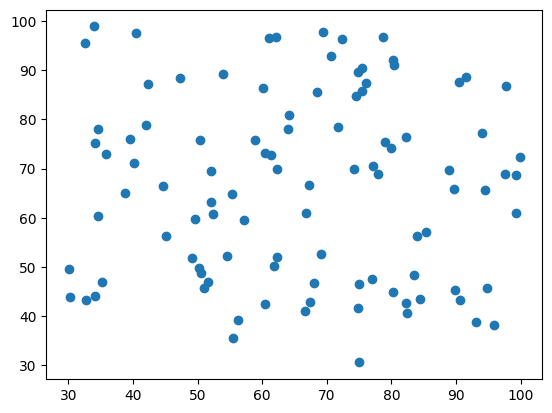

In [10]:
db = pd.read_csv('https://sharon.srworkspace.com/ml/datasets/hw4/exams.csv', header=None).to_numpy()
data, labels = db[:,:-1], db[:,-1]

plt.scatter(data[:, 0], data[:, 1])
plt.show()

We are going to divide the data into 2 clusters. <br/>
Define Kmeans object and fit the data.

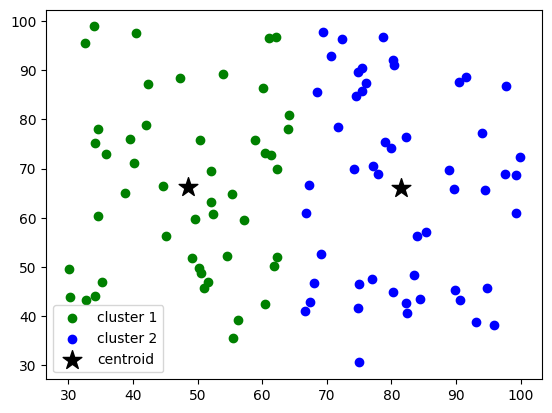

In [11]:
clust = Kmeans(n_clusters=2)
clust.fit(data)

# This code plots the clustered data with centroids
labels = clust.labels
centroids = clust.centroids

c0 = data[labels == 0]
c1 = data[labels == 1]

plt.scatter(c0[:,0], c0[:,1], c='green', label='cluster 1')
plt.scatter(c1[:,0], c1[:,1], c='blue', label='cluster 2')
plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', s=200, c='black', label='centroid')
plt.legend()

plt.show()

Use the Elbow Method to choose another number of centroids between 1-10. <br/>
<font color='red'>
The Elbow Method plot shows that the optimal number of clusters is 5, as this is the elbow point where the SSE starts to decrease more slowly.<br>
</font>

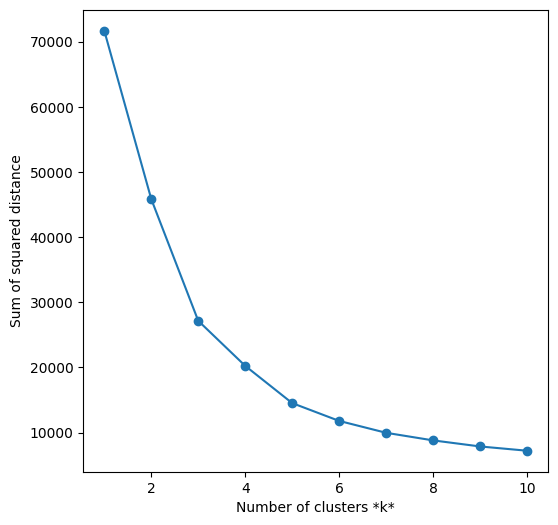

In [12]:
sse = []
list_k = list(range(1, 11))

for k in list_k:
  clust = Kmeans(n_clusters=k)
  clust.fit(data)
  error_of_current_clustering = clust.compute_sse(data, clust.labels, clust.centroids)
  sse.append(error_of_current_clustering)

'''Plot sse against k'''
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance')
plt.show()

Apply clustering with the selected k

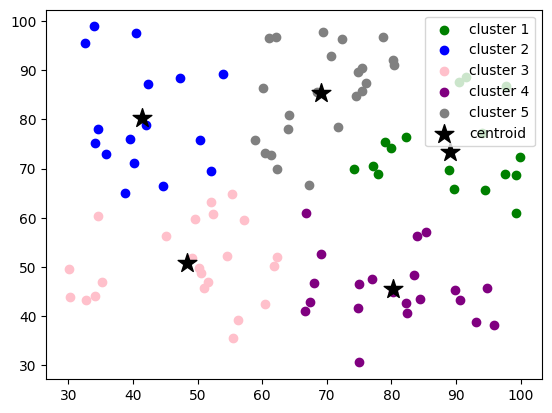

In [13]:
# Implement here
# Initialize cluster object clust with k=5
clust = Kmeans(n_clusters=5)

clust.fit(data)

# Plot the clustered data with centroids
labels = clust.labels
centroids = clust.centroids

c0 = data[labels == 0]
c1 = data[labels == 1]
c2 = data[labels == 2]
c3 = data[labels == 3]
c4 = data[labels == 4]


plt.scatter(c0[:, 0], c0[:, 1], c='green', label='cluster 1')
plt.scatter(c1[:, 0], c1[:, 1], c='blue', label='cluster 2')
plt.scatter(c2[:, 0], c2[:, 1], c='pink', label='cluster 3')
plt.scatter(c3[:, 0], c3[:, 1], c='purple', label='cluster 4')
plt.scatter(c4[:, 0], c4[:, 1], c='gray', label='cluster 5')

plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', s=200, c='black', label='centroid')
plt.legend()
plt.show()

Now, you will compress some image using k-means. <br/>
Here, you are given image from size 400x600x3. The last parameter is the number of channels. 3 channels means that the image is colored (unlike 1 in, which is grayscale). <br/>
Our goal is to reduce the number of colors to 20 and represent (compress) the photo using those 20 colors only. <br/>

Motivation: the original image requires 400x600x3x8 bits, while the new image will require only 400x600x5 + 20x24 bits, almost 5 times smaller!<br/>
To really do this, we will take the image and treat every pixel as a data point, where each data point is in 3d space (r,g,b). Then, we cluster into 20 centroids, and we assign each pixel to a centroid. This will allow us to represent the image using only 20 colors.


In [14]:
#@title helper function

import urllib.request

def read_image(url):
    req = urllib.request.urlopen(url)
    arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
    return cv2.imdecode(arr, -1)

Complete the missing code

In [15]:
from sklearn.cluster import KMeans
import cv2

img = read_image('https://sharon.srworkspace.com/ml/datasets/hw4/image.jpg')
img_size = img.shape

# Reshape it to be 2-dimension
X = img.reshape(img_size[0] * img_size[1], img_size[2])		# Turn hxwx3 into (h*w)x3

# Run the Kmeans algorithm
km = KMeans(n_clusters=20)
km.fit(X)

'''
The km has the following properties:
(*) km.labels_ is an array size (pixels, 20), will give each pixel its class from 20 classes (values are between 0-19)
(*) km.cluster_centers_ is an array size 20x3, where the ith row represents the color value for the ith label.
	For example, cluster_centers_[0] = [r,g,b], the first center.
'''

# Use the centroids to compress the image
img_compressed = km.cluster_centers_[km.labels_] # Use cluster_centers_ and labels_
img_compressed = np.clip(img_compressed.astype('uint8'), 0, 255)

# Reshape X_recovered to have the same dimension as the original image 128 * 128 * 3'''
img_compressed = img_compressed.reshape(img_size[0], img_size[1], img_size[2])

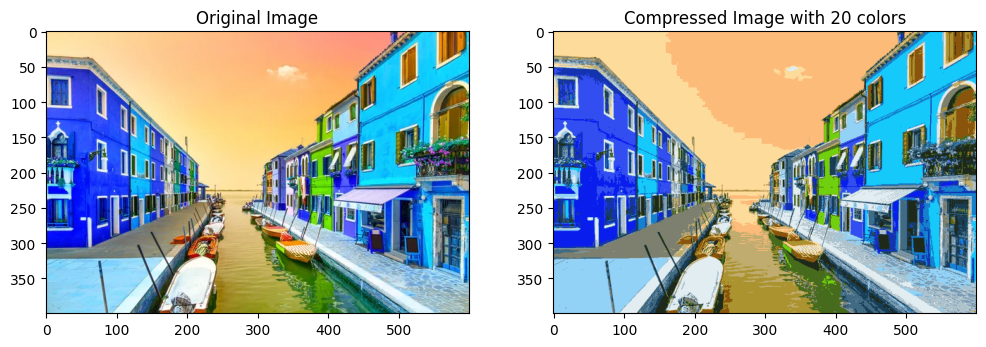

In [16]:

# Plot the original and the compressed image next to each other'''
plt.figure(figsize = (12, 4))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(img_compressed)
plt.title(f'Compressed Image with {km.n_clusters} colors')

plt.show()

## load smiling dataset

In the third question, we will deal with the Smiling-face dataset, which determines if a person is smiling or not. You will try several models and hope to get good results<br/>
Your task is: run the following section and make sure your understand what's going on.

Go to your <a href="https://www.kaggle.com/">Kaggle</a> account and under the settings, generate new API token. <br/>
This will give you the json file, which you will upload here.

In [ ]:
# The script expects you to upload JSON file to it!
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list
! kaggle datasets download chazzer/smiling-or-not-face-data
! unzip -q smiling-or-not-face-data.zip -d data

Saving kaggle.json to kaggle.json
ref                                                        title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
myrios/cost-of-living-index-by-country-by-number-2024      Cost of Living Index by Country                      3KB  2024-07-19 06:25:42           2341         30  1.0              
waqi786/cats-dataset                                       🐾 Cats Dataset                                       6KB  2024-07-31 06:12:49           2127         44  1.0              
muhammadehsan000/olympic-historical-dataset-1896-2020      Olympic Historical Dataset (1896 - 2022)            27MB  2024-08-06 16:46:08           1223         28  1.0              
patricklford/global-ev-sales-2010-2024                  

import libraries

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import os
import cv2

import warnings
warnings.filterwarnings('ignore')

process the images

In [ ]:
def proccess_data(folder):
	image_arrays = []
	for filename in os.listdir(folder):
		file_path = os.path.join(folder, filename)
		image = cv2.imread(file_path)
		gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
		image_arrays.append(gray_image)
	return np.array(image_arrays)

smile = proccess_data('./data/smile')
non_smile = proccess_data('./data/non_smile')

dataset = np.vstack((smile,non_smile))
dataset = dataset / 255

labels = [0] * len(smile) + [1] * len(non_smile)
labels = np.array(labels)

display smiling and non-smiling image.

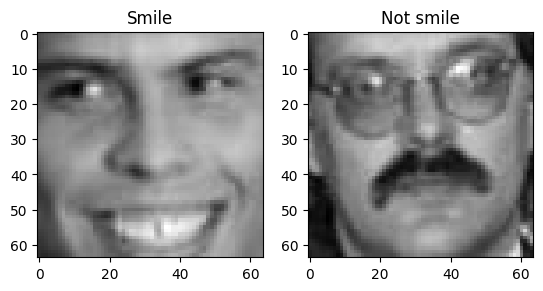

In [ ]:
plt.subplot(121)
plt.title("Smile")
plt.imshow(smile[0], cmap='gray')

plt.subplot(122)
plt.title("Not smile")
plt.imshow(non_smile[0], cmap='gray')

plt.show()

print the smiling and non-smiling data + the united dataset along with labels.

In [ ]:
print(f'smile array size is (images, height, width)={smile.shape}')
print(f'non smile array size is (images, height, width)={non_smile.shape}')
print()
print(f'dataset array size is {dataset.shape}')
print(f'labels array size is {labels.shape}')

smile array size is (images, height, width)=(600, 64, 64)
non smile array size is (images, height, width)=(603, 64, 64)

dataset array size is (1203, 64, 64)
labels array size is (1203,)


Prepear train and test datasets, print their structure. Since you have to deal with 1d features, we flatten the squared image

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(dataset, labels, test_size = 0.2, stratify=labels, random_state=42)

print(f'train size is {x_train.shape} and labels size is {y_train.shape}')
print(f'test size is {x_test.shape} and labels size is {y_test.shape}')
print()

x_train_flatten = x_train.reshape(x_train.shape[0], x_train.shape[1] * x_train.shape[2])
x_test_flatten = x_test.reshape(x_test.shape[0], x_test.shape[1] * x_test.shape[2])

print(f'flattened train size is {x_train_flatten.shape} ')
print(f'flattened test size is {x_test_flatten.shape}')

train size is (962, 64, 64) and labels size is (962,)
test size is (241, 64, 64) and labels size is (241,)

flattened train size is (962, 4096) 
flattened test size is (241, 4096)


## Question 3 - PCA, LDA

You will try to classify the smiling faces dataset using feature reduction and KNN (since there are 4096 features!). Than you will compare it to LDA

import libraries

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

Implement PCA to reduce the dimension of the images from 4096=64x64 to 81=9x9. For time effciency, DONT use any loops here.

Hint: Implement inverse_transform to recover the original vector from the compressed one. <br/>
Hint: When dealing with symmetric matrix, you can call eigh instead of eig function of numpy, its much faster.

In [ ]:
def PCA_train(data, k):
	# Implement here
	# Download data to k dimensions
	data = np.array(data)
	mu = data.mean(axis=0)
	Z = data - mu
	S = np.matmul(Z.transpose(), Z)
	eigenvalues, eigenvectors = np.linalg.eigh(S)
	sorted_indices = np.argsort(eigenvalues)[::-1]
	sorted_eigenvalues = eigenvalues[sorted_indices]
	sorted_eigenvectors = eigenvectors[:, sorted_indices]

	selected_eigenvectors = sorted_eigenvectors[:, :k]
	x_train_new = (np.matmul(selected_eigenvectors.transpose(), Z.transpose())).transpose()
	return (np.real(x_train_new), mu, selected_eigenvectors, eigenvalues)

def PCA_test(test, mu, E):
	# Implement here
	Z_test = test - mu
	new_test = np.dot(Z_test, E)
	return np.real(new_test)

def recover_PCA(data, mu, E):
	# Implement here
	reconstructed_data = np.dot(data, E.T) + mu
	return np.real(reconstructed_data)

Apply the PCA. <br/>
Make sure you fit the PCA model only to the training set (but apply it to both training and test sets). <br/>

In [ ]:
x_train_new, mu, eig, eigenvalues = PCA_train(x_train_flatten, 81)
x_test_new = PCA_test(x_test_flatten, mu, eig)

Pick another random image and show the result of applying PCA to it, and then try to recover the whole size again.

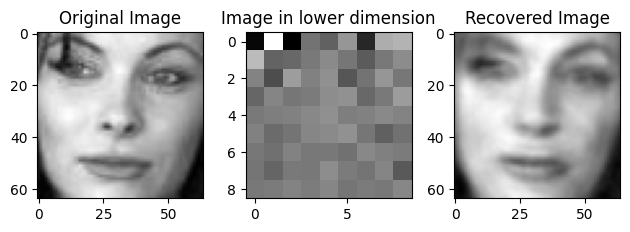

In [ ]:
original_image = x_train[0].reshape(64,64)
compressed_image = x_train_new[0]
compressed_image_square = compressed_image.reshape(9,9)

recovered_image = recover_PCA(compressed_image, mu, eig)
recovered_image_square = recovered_image.reshape(64,64)

plt.subplot(131)
plt.title("Original Image")
plt.imshow(original_image, cmap='gray')

plt.subplot(132)
plt.title("Image in lower dimension")
plt.imshow(compressed_image_square, cmap='gray')

plt.subplot(133)
plt.title("Recovered Image")
plt.imshow(recovered_image_square, cmap='gray')

plt.tight_layout()
plt.show()

Before training the model, use EIG_CDF, that given eigenvalues, draws a CDF of them like here:<br/><br/>

![Picture1.jpg](https://encrypted-tbn1.gstatic.com/images?q=tbn:ANd9GcS3mOZk1x4X3ap9nuMnst5W5pMgOXF8r3Tmx1QcFX9mba_lleuB)

As seen in the tutorials, we use them to see how much "energy" we preserve from the data. Use this to choose optimal dimension to reduce into, such the preserves 95% of the energy.

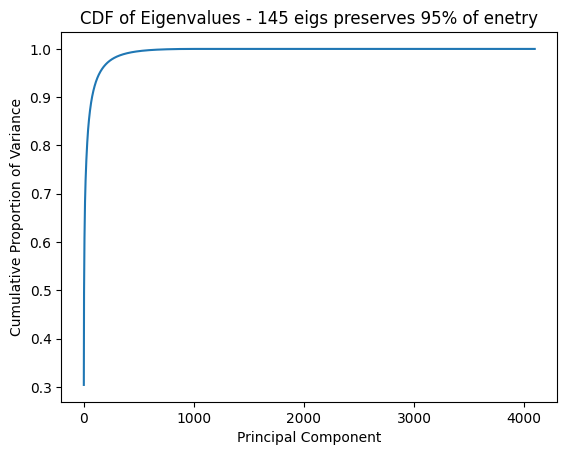

In [ ]:
def EIG_CDF(eig_list):
	sorted_eigenvalues = np.sort(eig_list)[::-1]

	eigenvalues_cumsum = np.cumsum(sorted_eigenvalues)

	eigenvalues_cumsum_normalized = eigenvalues_cumsum / eigenvalues_cumsum[-1]
	amount = np.argmax(eigenvalues_cumsum_normalized >= 0.95) + 1 # Implement here

	plt.plot(np.arange(1, len(sorted_eigenvalues)+1), eigenvalues_cumsum_normalized)
	plt.xlabel('Principal Component')
	plt.ylabel('Cumulative Proportion of Variance')
	plt.title(f'CDF of Eigenvalues - {amount} eigs preserves 95% of enetry')
	plt.show()

# Call to EIG_CDF
EIG_CDF(eigenvalues)

For the same image as before, show the result of applying PCA to it and recovering.<br/>
Is the result better? What is different from 81 dimensions? <br/>
<font color='red'>

Yes, obviously it is better.<br>
Using 144 dimensions for PCA gives a clearer, more detailed recovered image than using 81 dimensions. <br>The 144-dimensional image more closely resembles the original, showing that more principal components capture more information and improve image quality.
</font>

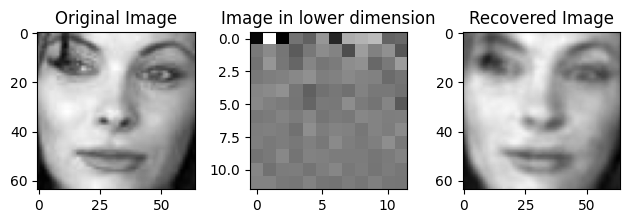

In [ ]:
x2_train_new, mu2, eig2, eig_values2 = PCA_train(x_train_flatten, 144)
x_test_new2 = PCA_test(x_test_flatten, mu2, eig2)

original_image = x_train[0].reshape(64, 64)
plt.subplot(131)
plt.title("Original Image")
plt.imshow(original_image, cmap='gray')
compressed_image = x2_train_new[0].reshape(12, 12)
compressed_image = np.real(compressed_image)

plt.subplot(132)
plt.title("Image in lower dimension")
plt.imshow(compressed_image, cmap='gray')

compressed_image_1d = compressed_image.flatten()
recovered_image = recover_PCA(compressed_image_1d, mu2, eig2)
recovered_image = np.real(recovered_image)
recovered_image_square = recovered_image.reshape(64,64)

plt.subplot(133)
plt.title("Recovered Image")
plt.imshow(recovered_image_square, cmap='gray')

plt.tight_layout()
plt.show()


Now, you are ready to train the model. Use KNN, tune the best k using cross_val_score (with sklearn)

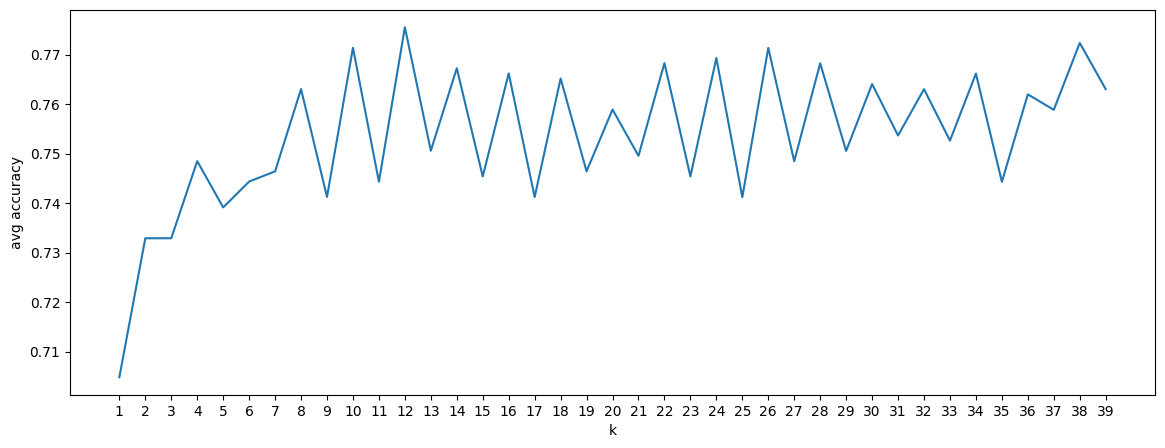

In [ ]:
# Implement here
ks = range(1, 40)

accs = []
max_avg_acc =0
for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, x_train_flatten, y_train, cv=5, scoring='accuracy')
    accs.append(scores.mean())

plt.figure(figsize=(14,5))
plt.plot(ks, accs)
plt.xlabel('k')
plt.xticks(ks)
plt.ylabel('avg accuracy')
plt.show()

Print the accuracy of your model on the test set.

In [ ]:
# Implement here
best_k = ks[np.argmax(accs)]
best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(x2_train_new, y_train)
acc = best_knn.score(x_test_new2, y_test)

print(f'acc on test is {acc}')
print(f'best K is {best_k}')

acc on test is 0.7925311203319502
best K is 12


Answer the following sum-up questions: <br/>
- What pre-proccessing actions were done on the data?<br>
<font color='red'>
The pre-processing actions done on the data include converting each image to grayscale, stacking the grayscale images corresponding to smiling and non-smiling faces, assigning labels based on their categories, splitting the dataset into training and testing sets, and flattening each image into a 1D array. Additionally, PCA was applied to reduce the dimensionality of the data, preserving 95% of the variance.
</font>
- Should we apply Standard Scaler? Why?<br>
<font color = red>
No, we shouln't apply Standard Scaler, because the pixel values are already within a similar range, and scaling could distort the inherent spatial relationships and meaningful patterns in the image data.
</font>
- Suggest one idea for improvement (rather than LDA)<br>
<font color = red>
To further improve the model, one potential approach is to use Bagging.
Bagging trains multiple models on random subsets of the data and combines their predictions, reducing variance and improving accuracy. This could lead to better classification results.
</font>



For the second part, we will use LDA on the data <b>before</b> PCA. <br/>
Use the model of LinearDiscriminantAnalysis from Sklearn, train the data and print the accuracy test using KNN. <br/>
Use the best k you found earlier.

In [ ]:
# Implement here
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

best_k = ks[np.argmax(accs)]

lda = LinearDiscriminantAnalysis()
x_train_lda = lda.fit_transform(x2_train_new, y_train)
x_test_lda = lda.transform(x_test_new2)

best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(x_train_lda, y_train)
acc_lda = best_knn.score(x_test_lda, y_test)

print(f'Accuracy Using LDA: {acc_lda}')


Accuracy Using LDA: 0.8796680497925311


Now, repeat the same as above, but using the data <b>after</b> PCA and using the same k.
- Was the combination of PCA and LDA helpful more than LDA alone?<br>
<font color=red>
Since the accuracy remains the same in both cases, the combination of PCA and LDA did not provide any additional benefit<br>
 over using LDA alone in terms of accuracy for this particular dataset and model configuration.
</font>

- Comparing LDA alone vs PCA alone (as dimensionality reduction), which one was better to this problem? Justify.<br>
<font color=red>
As we can see from the results, LDA alone performed better than PCA alone for this problem.<br>
This is because LDA uses labels to maximize class separability, which enhances the distinctions between different classes. In contrast, PCA focuses on capturing the most variance in the data without considering class labels, which can lead to less effective feature representation for classification tasks.



</font>


In [ ]:
# Applying LDA on the data after PCA
lda_after_pca = LinearDiscriminantAnalysis()
x_train_pca_lda = lda_after_pca.fit_transform(x2_train_new, y_train)
x_test_pca_lda = lda_after_pca.transform(x_test_new2)

best_knn_pca_lda = KNeighborsClassifier(n_neighbors=best_k)
best_knn_pca_lda.fit(x_train_pca_lda, y_train)
acc_pca_lda = best_knn_pca_lda.score(x_test_pca_lda, y_test)

print(f'Accuracy using PCA and LDA: {acc_pca_lda}')


Accuracy using PCA and LDA: 0.8796680497925311


## Question 4 - Adaboost
See attached pdf in moodle assignment!



## Question 5 - Kernel PCA - 10 pts bonus
See attached pdf in moodle assignment! <br/>
Here you will implement the parts that are relevant for that question

In [ ]:
# Implement here everything you need
import numpy as np
from sklearn.decomposition import KernelPCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

kpca = KernelPCA(n_components=144, kernel='cosine')
x_train_kpca = kpca.fit_transform(x_train_flatten)
x_test_kpca = kpca.transform(x_test_flatten)
knn = KNeighborsClassifier(n_neighbors=125)
knn.fit(x_train_kpca, y_train)

y_pred_kpca = knn.predict(x_test_kpca)
acc_kpca = accuracy_score(y_test, y_pred_kpca)

print(f"Kernel PCA with cosine kernel Accuracy: {acc_kpca}")

Kernel PCA with cosine kernel Accuracy: 0.8298755186721992
